Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [66]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/ediprodan/Documents/FER/1_sem/struce1/struce_venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['clf', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [67]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [68]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [69]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

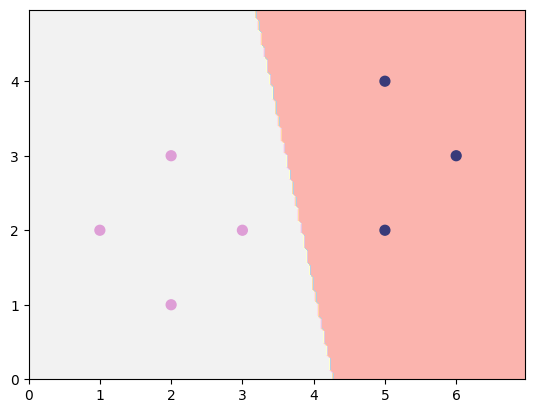

1.0

In [70]:
# Vaš kôd ovdje
clf = RidgeClassifier().fit(seven_X, seven_y)
clf.predict(seven_X)
plot_2d_clf_problem(seven_X, seven_y, clf.predict)
plt.show()
clf.score(seven_X, seven_y)

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

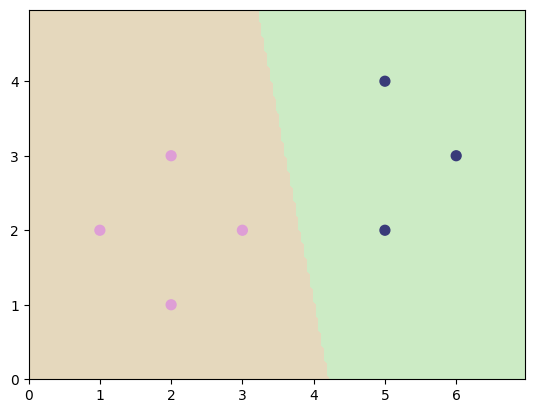

In [71]:
# Vaš kôd ovdje
reg = LinearRegression().fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, lambda x : reg.predict(x) >= 0.5)
plt.show()

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [72]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

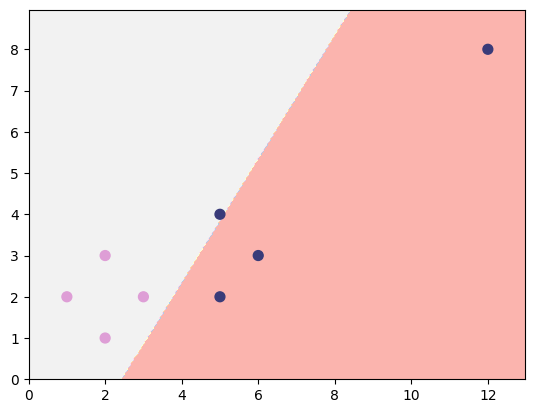

0.875

In [73]:
# Vaš kôd ovdje
clf = RidgeClassifier().fit(outlier_X, outlier_y)
clf.predict(outlier_X)
plot_2d_clf_problem(outlier_X, outlier_y, clf.predict)
plt.show()
clf.score(outlier_X, outlier_y)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [74]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

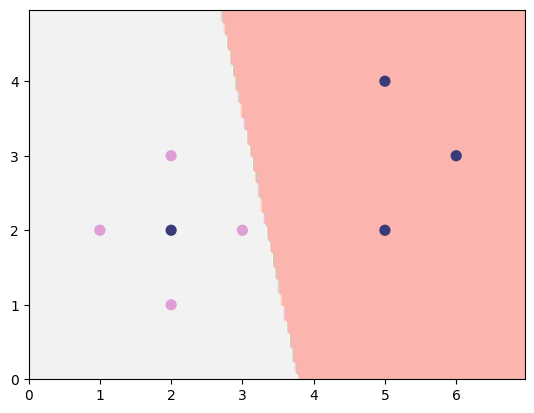

0.875

In [75]:
# Vaš kôd ovdje
clf = RidgeClassifier().fit(unsep_X, unsep_y)
clf.predict(unsep_X)
plot_2d_clf_problem(unsep_X, unsep_y, clf.predict)
plt.show()
clf.score(unsep_X, unsep_y)


**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

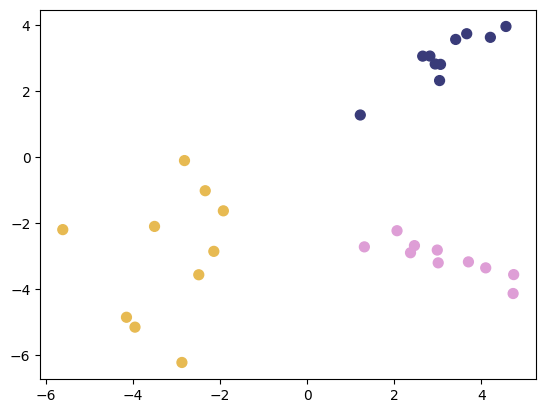

In [76]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=30, n_classes=3, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, class_sep=3.0)
plot_2d_clf_problem(X, y)
plt.show()

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

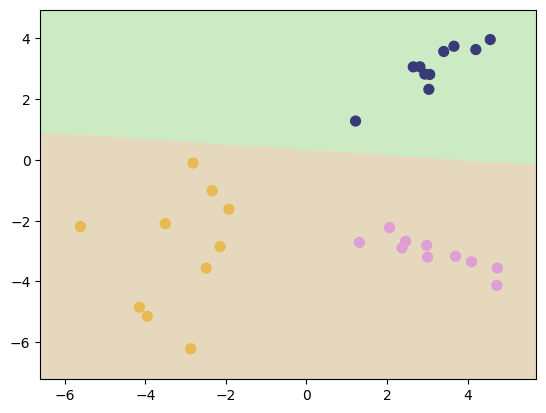

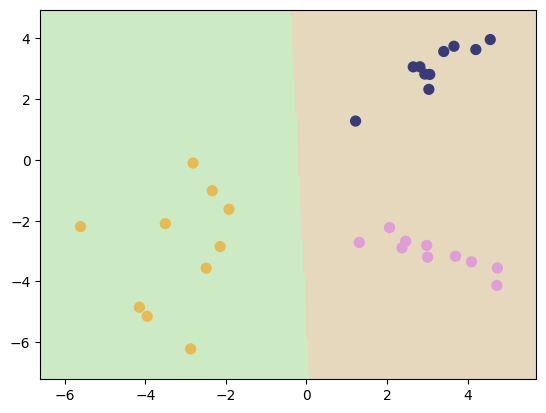

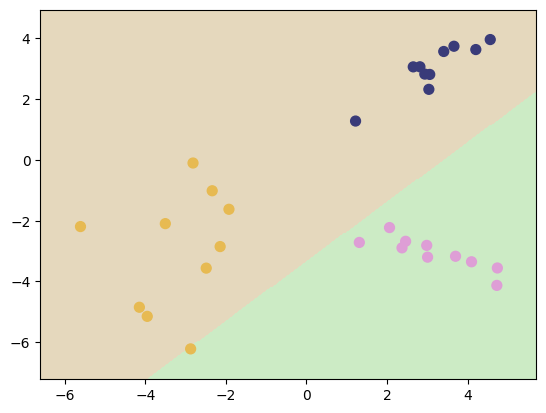

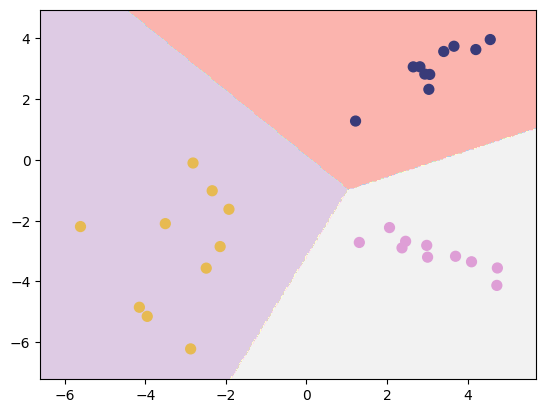

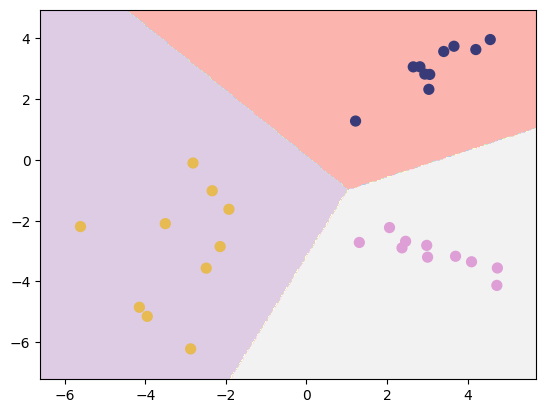

In [77]:
# Vaš kôd ovdje
y0 = np.array([0 if i == 0 else 1 for i in y])
y1 = np.array([0 if i == 1 else 1 for i in y])
y2 = np.array([0 if i == 2 else 1 for i in y])

models = []
reg0 = LinearRegression().fit(X, y0)
reg1 = LinearRegression().fit(X, y1)
reg2 = LinearRegression().fit(X, y2)

models.append(reg0)
models.append(reg1)
models.append(reg2)

plot_2d_clf_problem(X, y, lambda x : reg0.predict(x) >= 0.5)
plt.show()
plot_2d_clf_problem(X, y, lambda x : reg1.predict(x) >= 0.5)
plt.show()
plot_2d_clf_problem(X, y, lambda x : reg2.predict(x) >= 0.5)
plt.show()

clf = RidgeClassifier().fit(X, y)
plot_2d_clf_problem(X, y, clf.predict)
plt.show()

def predict(X):
    
    class_predictions = []
    predictions = []
    for model in models:
        predictions.append(model.predict(X))

    for x in range(len(predictions[0])):
        min_ = float('inf')
        for class_ in range(len(predictions)):
            if predictions[class_][x] < min_:
                min_ = predictions[class_][x]
                min_class = class_

        class_predictions.append(min_class)

    return np.array(class_predictions)

    
plot_2d_clf_problem(X, y, predict) 
plt.show()

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

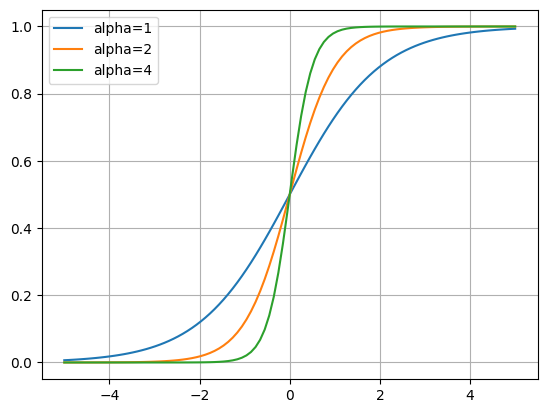

In [78]:
# Vaš kôd ovdje
def sigm(x, alpha = 1):
    return 1 / (1 + np.exp(-alpha * x))

x = np.linspace(-5, 5, 100)
plt.plot(x, sigm(x, 1), label="alpha=1")
plt.plot(x, sigm(x, 2), label="alpha=2")
plt.plot(x, sigm(x, 4), label="alpha=4")
plt.legend()
plt.grid()
plt.show()


**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [79]:
from numpy import linalg

def lr_h(x, w, w0):
    w = np.insert(w, 0, w0)
    return sigm(np.dot(x, w))

def cross_entropy_error(X, y, w, w0, f=False):
    if not f:
        X = np.insert(X, 0, 1, axis=1)
    error = 0
    for i in range(len(X)):
        h = lr_h(X[i], w, w0)
        error += (- y[i] * np.log(h) - (1 - y[i]) * np.log(1 - h))

    return error/len(X)

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    
    # Vaš kôd ovdje
    n = X.shape[1] 
    w = np.zeros(n)
    w0 = 0 
    
    X = np.insert(X, 0, 1, axis=1)
    trace_w = [] 
    current_err = cross_entropy_error(X,y,w,w0, f=True)

    
    for _ in range(max_iter):
        dw = np.zeros(n) 
        dw0 = 0 
            
        for i in range(len(X)):
            h = lr_h(X[i], w, w0) 
            dw = dw - (h - y[i]) * X[i][1:]
            dw0 = dw0 - (h - y[i])
        w0 += eta * dw0
        w = w * (1-eta * alpha) + eta * dw
        if trace:
            trace_w.append((w.copy(), w0))
        new_err = cross_entropy_error(X,y,w,w0, f=True)
        err_diff = np.abs(new_err - current_err)
        if (err_diff < epsilon):
            break
        current_err = new_err

    if trace: 
        return w, w0, trace_w
    return w, w0

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [80]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])

seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

[-1.71089242  0.68413507] 4.4544945420360165
0.13521872720206746


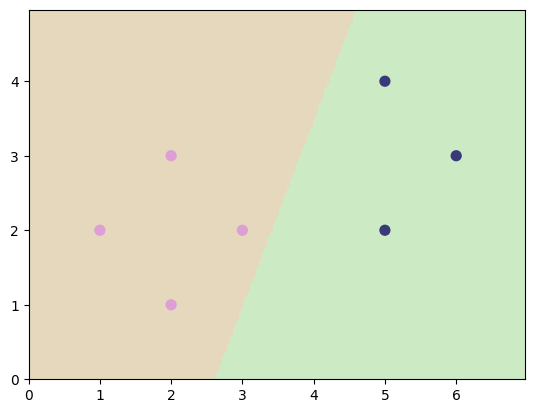

In [81]:
# Vaš kôd ovdje
w, w0, trace = lr_train(seven_X, seven_y, trace=True)

print(w, w0)
print(cross_entropy_error(seven_X, seven_y, w, w0))

plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(np.insert(x, 0,1), w, w0) >= 0.5)
plt.show()


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

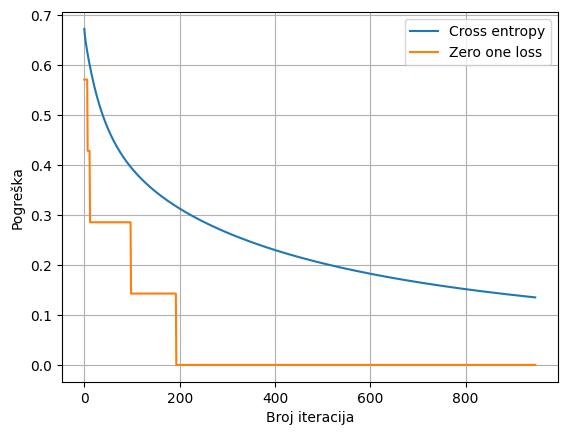

In [82]:
from sklearn.metrics import zero_one_loss

cross_entropy_err = []
zero_one_loss_err = []


for (w, w0) in trace:
    cross_entropy_err.append(cross_entropy_error(seven_X, seven_y, w, w0))
    y_pred = [lr_h(np.insert(x, 0,1), w, w0)>=0.5 for x in seven_X]
    zero_one_loss_err.append(zero_one_loss(seven_y, y_pred))

plt.plot(cross_entropy_err, label="Cross entropy")
plt.plot(zero_one_loss_err, label="Zero one loss")
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("Pogreška")
plt.grid()
plt.show()

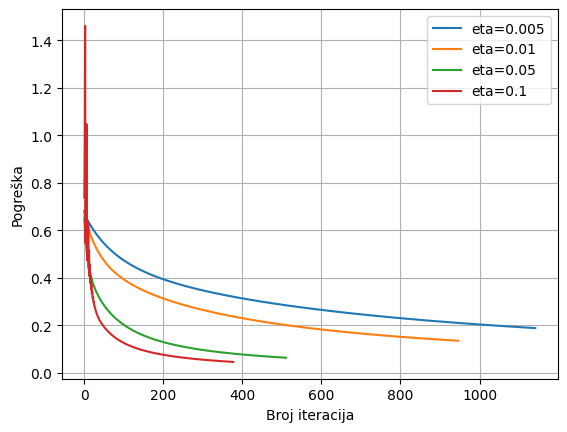

In [83]:
# Vaš kôd ovdje

eta_list = [0.005, 0.01, 0.05, 0.1]
cross_entropy_err = []

for eta in eta_list:
    w, w0, trace = lr_train(seven_X, seven_y, eta=eta, trace=True)
    y = []
    for (w, w0) in trace:
        y.append(cross_entropy_error(seven_X, seven_y, w, w0))
    cross_entropy_err.append(y)

for i in range(len(eta_list)):
    plt.plot(cross_entropy_err[i], label=f"eta={eta_list[i]}")
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("Pogreška")
plt.grid()
plt.show()



**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

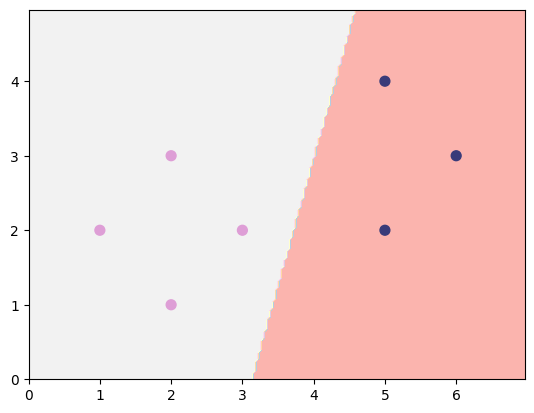

[[-14.80304235   4.33454163]] [46.26968486]
[21]


In [84]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
clf = LogisticRegression(penalty=None)
clf.fit(seven_X, seven_y)

plot_2d_clf_problem(seven_X, seven_y, clf.predict)
plt.show()


print(clf.coef_, clf.intercept_)
print(clf.n_iter_)


### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [85]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

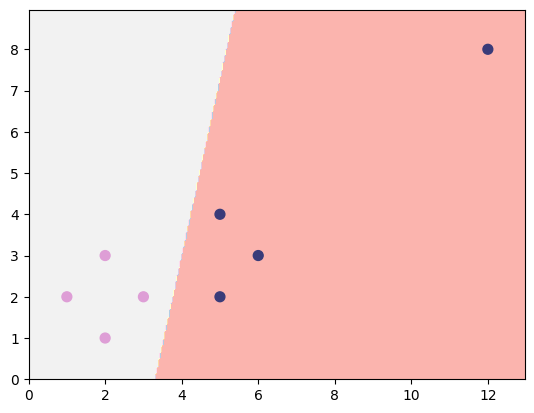

In [86]:
# Vaš kôd ovdje
clf = LogisticRegression(penalty=None)
clf.fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, clf.predict)
plt.show()

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

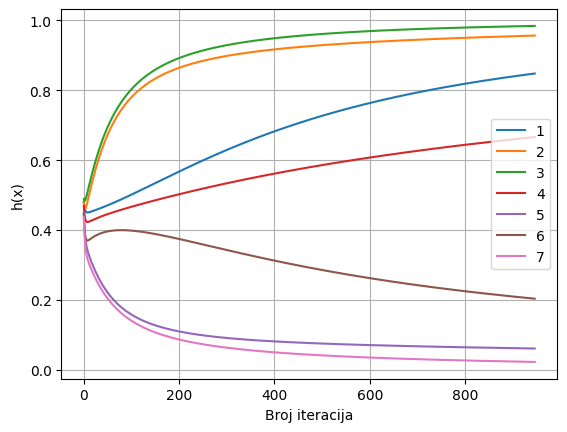

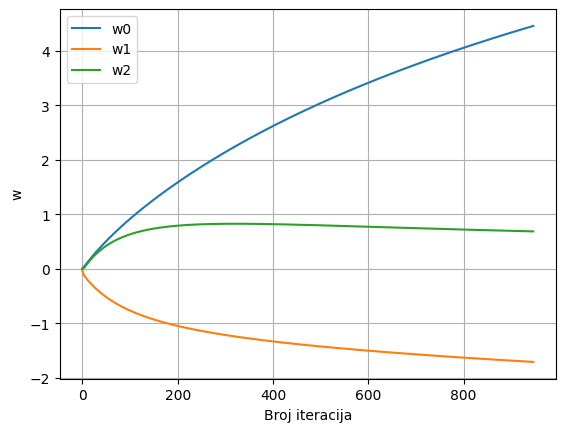

In [87]:
def h_w_plot(X, y):
    w, w0, trace_w = lr_train(X, y, trace=True)
    
    
    h_list = []
    for i in range(len(X)):
        h_list.append([])
    for (w, w0) in trace_w:
        for i,x in enumerate(X):
            h_list[i].append(lr_h(np.insert(x, 0,1), w, w0))

    for i,h in enumerate(h_list, start=1):
        plt.plot(h, label=f"{i}")
    plt.legend()
    plt.xlabel("Broj iteracija")
    plt.ylabel("h(x)")
    plt.grid()
    plt.show()

    # weights w0, w1 and w2 over time 
    w0_list = []
    w1_list = []
    w2_list = []
    for (w, w0) in trace_w:
        w0_list.append(w0)
        w1_list.append(w[0])
        w2_list.append(w[1])

    plt.plot(w0_list, label="w0")
    plt.plot(w1_list, label="w1")
    plt.plot(w2_list, label="w2")
    plt.legend()
    plt.xlabel("Broj iteracija")
    plt.ylabel("w")
    plt.grid()
    plt.show()


h_w_plot(seven_X, seven_y)

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [88]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

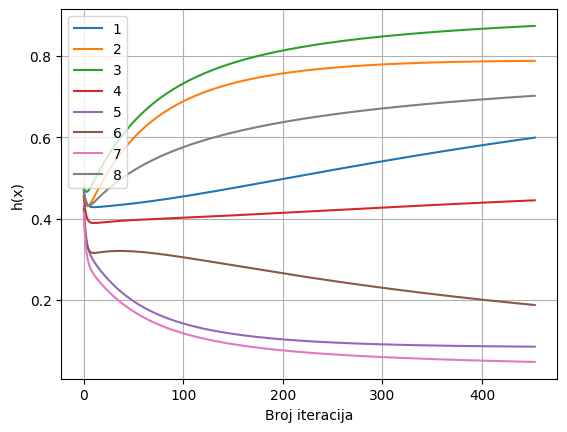

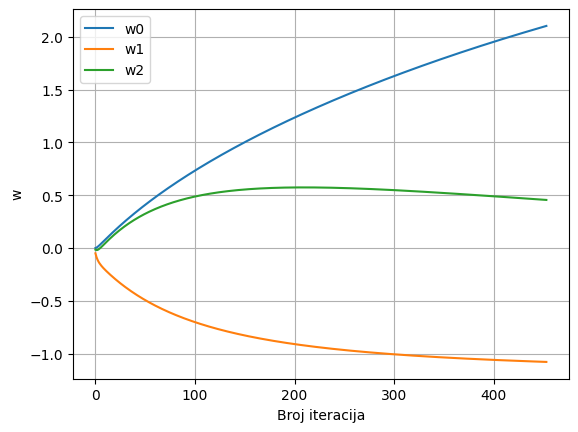

In [89]:
# Vaš kôd ovdje
h_w_plot(unsep_X, unsep_y)

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [90]:
from numpy.linalg import norm

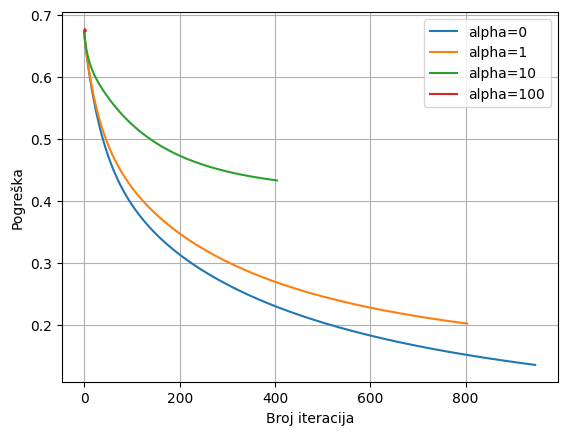

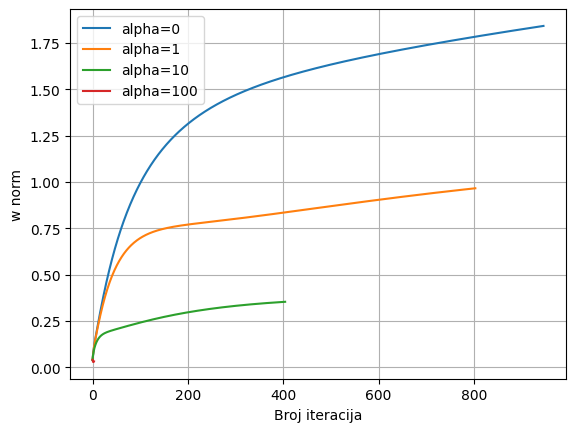

In [91]:
# Vaš kôd ovdje
alpha_list = [0, 1, 10, 100]

cross_entropy_err = []
w_norm = []

for alpha in alpha_list:
    w, w0, trace_w = lr_train(seven_X, seven_y, alpha=alpha,trace=True)
    y_err, y_norm = [], []
    for (w, w0) in trace_w:
        y_err.append(cross_entropy_error(seven_X, seven_y, w, w0))
        y_norm.append(norm(w, ord=2))
    cross_entropy_err.append(y_err)
    w_norm.append(y_norm)

for i in range(len(alpha_list)):
    plt.plot(cross_entropy_err[i], label=f"alpha={alpha_list[i]}")
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("Pogreška")
plt.grid()
plt.show()

for i in range(len(alpha_list)):
    plt.plot(w_norm[i], label=f"alpha={alpha_list[i]}")
plt.legend(loc="best")
plt.xlabel("Broj iteracija")
plt.ylabel("w norm")
plt.grid()
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

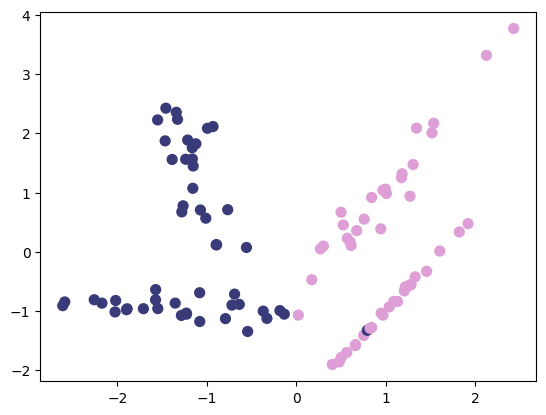

In [92]:
from sklearn.preprocessing import PolynomialFeatures

# Vaš kôd ovdje
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)
plot_2d_clf_problem(X, y)

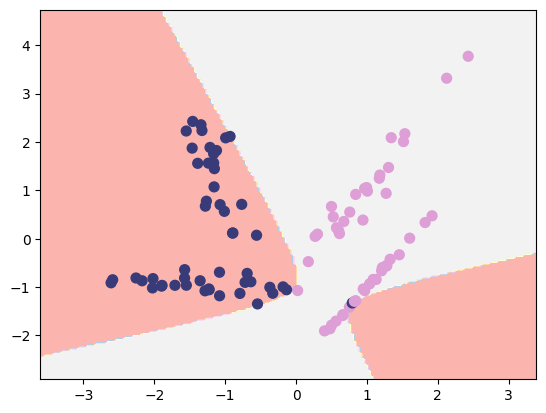

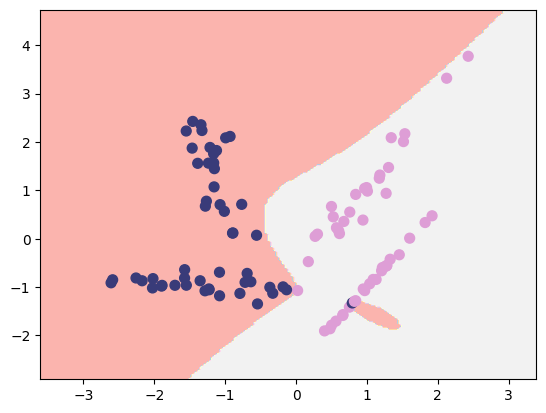

In [93]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)
phi2 = poly2.fit_transform(X)
phi3 = poly3.fit_transform(X)

clf = LogisticRegression(penalty=None)
clf.fit(phi2, y)
plot_2d_clf_problem(X, y, lambda x : clf.predict(poly2.fit_transform(x)))
plt.show()
clf.fit(phi3, y)
plot_2d_clf_problem(X, y, lambda x : clf.predict(poly3.fit_transform(x)))
plt.show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?